# Healthcare Data Acquisition

The goal of this notebook is to help with the overall wildland fire analysis for Indianapolis, Indiana, by loading and exploring all the healthcare data.

The notebook will also combine all the data into a single dataframe and save it for further analysis. 

## License

The code lies under the standard [MIT licence](./LICENSE).

## Setup

In [1]:
#########
#
#    IMPORTS
#

# In-built libraries
import os
import json

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

## State-Level Chronic Respiratory Illness Data

[Global Burden of Disease (GBD)](https://vizhub.healthdata.org/gbd-results/)

In [2]:
#########
#
#    CONSTANTS
#
IHME_STATE_DATA_PATH = 'data/IHME-GBD_2021_DATA-23c5e5a1-1.csv'

In [3]:
ihme_state_data_df = pd.read_csv(IHME_STATE_DATA_PATH)

In [4]:
IHME_STATE_RELEVANT_COLUMNS = [
    # 'measure_id', 
    'measure_name', 
    # 'location_id', # Always 537
    # 'location_name', # Always Indiana
    # 'sex_id', # Always 3
    # 'sex_name', # Always Both
    # 'age_id',  # Always 22
    # 'age_name', # Always All Ages
    # 'cause_id', 
    'cause_name', 
    # 'metric_id',
    'metric_name', 
    'year', 
    'val', 
    'upper', 
    'lower']

In [5]:
ihme_state_data_df = ihme_state_data_df[IHME_STATE_RELEVANT_COLUMNS]
ihme_state_data_df.head(2)

,measure_name,cause_name,metric_name,year,val,upper,lower
0,Deaths,Chronic respiratory diseases,Number,1981,1760.687643,1842.131881,1655.201869
1,Deaths,Chronic respiratory diseases,Percent,1981,0.037321,0.039017,0.035005


In [6]:
print(ihme_state_data_df['measure_name'].unique())
print(ihme_state_data_df['cause_name'].unique())
print(ihme_state_data_df['metric_name'].unique())

['Deaths' 'Prevalence' 'Incidence']
['Chronic respiratory diseases' 'Chronic obstructive pulmonary disease'
 'Asthma']
['Number' 'Percent' 'Rate']


In [7]:
ihme_state_data_rates_df = ihme_state_data_df[ihme_state_data_df['metric_name'] == 'Rate']
ihme_state_data_numbers_df = ihme_state_data_df[ihme_state_data_df['metric_name'] == 'Number']

In [12]:
# Pivot the data to have the years as index
ihme_state_data_rates_df = ihme_state_data_rates_df.pivot(index='year', columns=['measure_name', 'cause_name'])
ihme_state_data_numbers_df = ihme_state_data_numbers_df.pivot(index='year', columns=['measure_name', 'cause_name'])

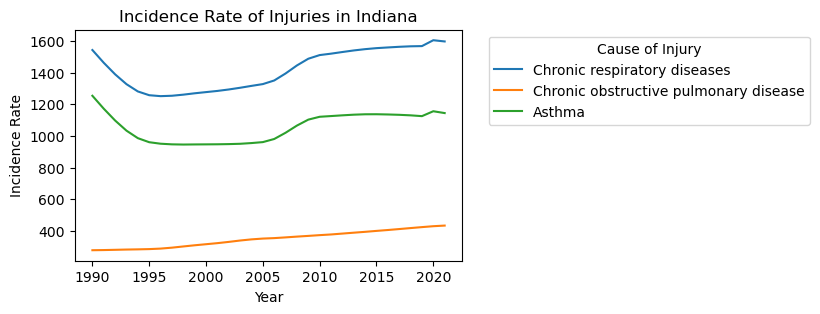

In [23]:
# Plot the incidence rates of the different causes of injury
fig = plt.figure(figsize=(5, 3))
ihme_state_data_rates_df['val']['Incidence'].plot(ax = plt.gca())
plt.xlabel('Year')
plt.ylabel('Incidence Rate')
plt.title('Incidence Rate of Injuries in Indiana')
plt.legend(title='Cause of Injury', bbox_to_anchor=(1.05, 1), loc='upper left')

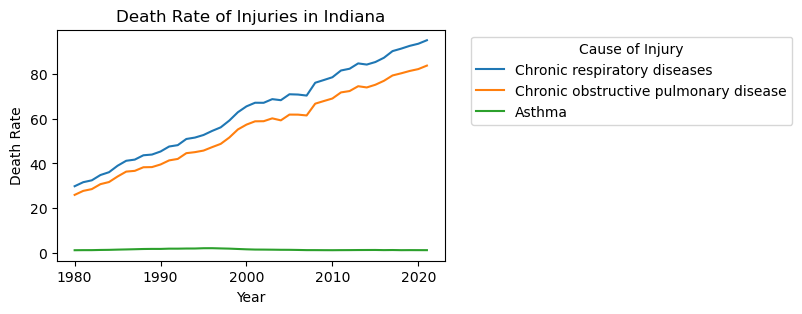

In [27]:
# Plot the death rates of the different causes of injury
fig = plt.figure(figsize=(5, 3))
ihme_state_data_rates_df['val']['Deaths'].plot(ax = plt.gca())
plt.xlabel('Year')
plt.ylabel('Death Rate')
plt.title('Death Rate of Injuries in Indiana')
plt.legend(title='Cause of Injury', bbox_to_anchor=(1.05, 1), loc='upper left')

As it turns out, while asthma is more prevalent among patients of Respiratory illnesses, COPD seems to be consistently responsible for most of the Respiratory Illness-related deaths in Indiana. 

